Populating the interactive namespace from numpy and matplotlib


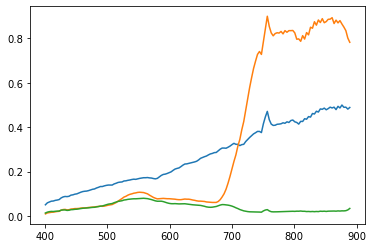

In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

figure(1)
plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])

plt.show()




In [2]:
def create_sythentic_hypercube(a_map, spectra, wavelength):
 
    '''
    Encodes a 2d image with spectral data to generate a synthetic hypercube.
    
    Inputs:
        a_map (N x M x L array) - 3D abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
    
    Output:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    '''

    N,M,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,M,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,:,i],spectra[i]).reshape((N,M,Q))

    return hypercube, wavelength

In [3]:
hypercube_noiseless,wavelength = create_sythentic_hypercube(a_map, spectra, wavelength)

In [4]:
hypercube_noiseless.shape


(95, 95, 156)

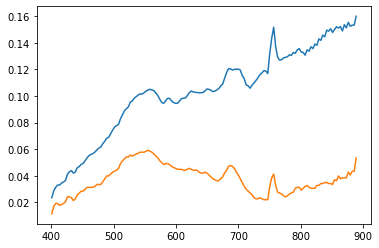

In [5]:
plot(wavelength,hypercube_noiseless[20,20,:])
plot(wavelength,hypercube[20,20,:])

In [6]:
y_true = hypercube_noiseless[20,20,:]
y_pred = hypercube[20,20,:]

In [8]:
from  pysptools import distance

N,M,L = a_map.shape
map_sam = zeros((N,M))
for i in range(N):
    for j in range (M):
        y_true = hypercube_noiseless[i,j,:]
        y_pred = hypercube[i,j,:]
        map_sam[i,j] = distance.SAM(y_true,y_pred)


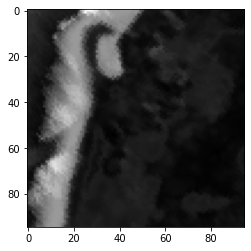

In [10]:
imshow(map_sam,cmap=cm.gray)